In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing ins

In [21]:
# Download the needed libraries
import ultralytics
from ultralytics import YOLO
import os
from collections import Counter, defaultdict
import shutil
import random
from torch.utils.data import random_split
import torch
from PIL import Image
import matplotlib.pyplot as plt
import yaml
from torch import cuda
import zipfile
from pathlib import Path
from IPython.display import Image, display
from PIL import Image
yolo = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 53.3MB/s]


In [25]:
# Detect hardware
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using {device}")

Using cuda


In [26]:
# Kaggle directory
dataset_dir = "/kaggle/input/obj-detectdataset/Obj_DetectDataset"
os.listdir(dataset_dir)

['README.dataset.txt',
 'README.roboflow.txt',
 'data.yaml',
 'valid',
 'test',
 'train']

In [17]:
data_yaml = os.path.join(dataset_dir, "data.yaml")
# Print the content in data_yaml
with open(data_yaml, 'r') as f:
    content = f.read()
    print(f"=== Content of data.yaml ===")
    print(content)

=== Content of data.yaml ===
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['flooded_building', 'flooded_car', 'person', 'person_in_help']

roboflow:
  workspace: columbia-university-d9ggz
  project: flood-object-detection-2olqp
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/columbia-university-d9ggz/flood-object-detection-2olqp/dataset/1


In [18]:
# Function to load class names from data.yaml
def load_class_names(data_yaml):
    with open(data_yaml, 'r') as f:
        data = yaml.safe_load(f)  # Load YAML content
        return data['names']  # Return the 'names' list from the YAML

# Load class names from data.yaml
class_names = load_class_names(data_yaml)
class_names

['flooded_building', 'flooded_car', 'person', 'person_in_help']

In [31]:
# Check if class name present in yolo_values
print("Result:")
for name in class_names:
  print(f"Absence of: {name} = {name not in yolo.names.values()}")

Result:
Absence of: flooded_building = True
Absence of: flooded_car = True
Absence of: person = False
Absence of: person_in_help = True


In [20]:
# Define the path to your dataset directory and the file
file_path = os.path.join(dataset_dir, 'README.roboflow.txt')

# Read and print the content of the file
with open(file_path, 'r') as file:
    readme_content = file.read()

print(readme_content)


Flood Object Detection - v1 2023-12-05 8:28pm

This dataset was exported via roboflow.com on December 9, 2023 at 11:26 PM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 330 images.
Flooded-building-car-people are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.





In [27]:
# Define directories
train_path = os.path.join(dataset_dir, "train")
train_image_path = os.path.join(train_path, "images")
train_label_path = os.path.join(train_path, "labels")
print("===== Train Folder =====")
print(f"Length of images in my train folder: {len(os.listdir(train_image_path))} images")
print(f"Length of labels in my train folder: {len(os.listdir(train_label_path))} labels")
test_path = os.path.join(dataset_dir, "test")
test_image_path = os.path.join(test_path, "images")
test_label_path = os.path.join(test_path, "labels")
print("===== Test Folder =====")
print(f"Length of images in my test folder: {len(os.listdir(test_image_path))} images")
print(f"Length of labels in my test folder: {len(os.listdir(test_label_path))} labels")
val_path = os.path.join(dataset_dir, "valid")
val_image_path = os.path.join(val_path, "images")
val_label_path = os.path.join(val_path, "labels")
print("===== Valid Folder =====")
print(f"Length of images in my valid folder: {len(os.listdir(val_image_path))} images")
print(f"Length of labels in my valid folder: {len(os.listdir(val_label_path))} labels")

===== Train Folder =====
Length of images in my train folder: 232 images
Length of labels in my train folder: 232 labels
===== Test Folder =====
Length of images in my test folder: 32 images
Length of labels in my test folder: 32 labels
===== Valid Folder =====
Length of images in my valid folder: 66 images
Length of labels in my valid folder: 66 labels


In [12]:
# Print the content in train_label_path
for label in os.listdir(train_label_path):
    path = os.path.join(train_label_path, label)
    #lines = []
    with open(path, 'r') as f:
        content = f.read()
        print(f"=== Content of {label} ===")
        print(content)

=== Content of flood_577_png.rf.c923493cec94dfe26d6629f587d1a676.txt ===
1 0.509375 0.60625 0.83125 0.6171875
=== Content of flood_751_png.rf.62e5e1a36f8c551d2a9e20e18ebf25be.txt ===
1 0.346875 0.45625 0.64296875 0.34921875
0 0.2234375 0.2375 0.446875 0.475
=== Content of flood_644_png.rf.be90882ad0b234e7a5c0a2885f7e5fa9.txt ===

=== Content of flood_95_png.rf.6d73b3ad883f50d159b01a8d2b424cd5.txt ===
1 0.48515625 0.45390625 0.2890625 0.20390625
0 0.765625 0.290625 0.46796875 0.31328125
0 0.16484375 0.3484375 0.32265625 0.2671875
=== Content of flood_46_png.rf.946341a022c2344e2d0e12046462ccba.txt ===
0 0.5015625 0.465625 0.94140625 0.85234375
=== Content of flood_804_png.rf.6bfcb49ecb701967fcae970d38e64304.txt ===
1 0.4734375 0.4203125 0.7640625 0.3078125
1 0.18125 0.2328125 0.36015625 0.225
=== Content of flood_748_png.rf.e9b576bb203a287df3e4459aac33f84b.txt ===
3 0.32421875 0.478125 0.1859375 0.43515625
1 0.61640625 0.40390625 0.49921875 0.45625
=== Content of flood_295_png.rf.78f0577

In [9]:
# Count class_id per label_directory
total_counts = defaultdict(int)
label_dir = [train_label_path, test_label_path, val_label_path]
for label_folder in label_dir:
    class_counter = defaultdict(int)
    for label in os.listdir(label_folder):
        path = os.path.join(label_folder, label)
        with open(path, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.strip()[0])
                    class_counter[class_id] += 1
                    total_counts[class_id] += 1
    print(f"\n Class Counts in {label_folder}")
    for class_id, count in sorted(class_counter.items()):
        print(f"Class Counts for {class_id}: {count}")
print(f"\n Total Class Counts Across All Folders:")
for class_id, count in sorted(total_counts.items()):
    print(f"Class Counts for {class_id}: {count}")


 Class Counts in /kaggle/input/obj-detectdataset/Obj_DetectDataset/train/labels
Class Counts for 0: 382
Class Counts for 1: 237
Class Counts for 2: 58
Class Counts for 3: 268

 Class Counts in /kaggle/input/obj-detectdataset/Obj_DetectDataset/test/labels
Class Counts for 0: 54
Class Counts for 1: 26
Class Counts for 2: 13
Class Counts for 3: 20

 Class Counts in /kaggle/input/obj-detectdataset/Obj_DetectDataset/valid/labels
Class Counts for 0: 69
Class Counts for 1: 80
Class Counts for 2: 13
Class Counts for 3: 87

 Total Class Counts Across All Folders:
Class Counts for 0: 505
Class Counts for 1: 343
Class Counts for 2: 84
Class Counts for 3: 375


In [29]:
# Redefine class_id
# Paths
src_dataset_path = "/kaggle/input/obj-detectdataset/Obj_DetectDataset"
working_dataset_path = "/kaggle/working/Obj_DetectDataset"

# Copy dataset to working directory
shutil.copytree(src_dataset_path, working_dataset_path, dirs_exist_ok=True)

# Update label paths
train_label_path = os.path.join(working_dataset_path, 'train', 'labels')
test_label_path = os.path.join(working_dataset_path, 'test', 'labels')
val_label_path = os.path.join(working_dataset_path, 'valid', 'labels')  # or 'val', depending on your dataset

# Class mapping
class_id_mapping = {'3': '2'}

def fix_class_id(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    updated_lines = []
    for line in lines:
        values = line.split()
        if values:
            class_id = values[0]
            if class_id in class_id_mapping:
                values[0] = class_id_mapping[class_id]
            updated_lines.append(' '.join(values) + '\n')
    with open(label_file, 'w') as f:
        f.writelines(updated_lines)

# Apply fixes
for label_path in [train_label_path, test_label_path, val_label_path]:
    for label_file in os.listdir(label_path):
        file_path = os.path.join(label_path, label_file)
        fix_class_id(file_path)
    print(f"Fixed label files: {label_path}")

Fixed label files: /kaggle/working/Obj_DetectDataset/train/labels
Fixed label files: /kaggle/working/Obj_DetectDataset/test/labels
Fixed label files: /kaggle/working/Obj_DetectDataset/valid/labels


In [30]:
# Update image paths
train_image_path = "/kaggle/working/Obj_DetectDataset/train/images"
test_image_path = "/kaggle/working/Obj_DetectDataset/test/images"
val_image_path = "/kaggle/working/Obj_DetectDataset/valid/images"

In [11]:
# Print the content in train_label_path
for label in os.listdir(train_label_path):
    path = os.path.join(train_label_path, label)
    #lines = []
    with open(path, 'r') as f:
        content = f.read()
        print(f"=== Content of {label} ===")
        print(content)

=== Content of flood_638_png.rf.6b4360b3866d7d989006c1780843af0d.txt ===
1 0.203125 0.68203125 0.39453125 0.42890625
1 0.821875 0.7 0.35625 0.315625
2 0.47578125 0.67734375 0.134375 0.35703125
2 0.58984375 0.6796875 0.1046875 0.275

=== Content of flood_563_png.rf.f31f0d4b3634d827180eb0b69798ec84.txt ===
1 0.253125 0.53984375 0.3359375 0.315625
1 0.72734375 0.55 0.2734375 0.1609375

=== Content of flood_784_png.rf.118b306710801cfbf18856539d4b0c7d.txt ===
1 0.7453125 0.54296875 0.4859375 0.2484375
1 0.5828125 0.16328125 0.48984375 0.21328125
1 0.1890625 0.4890625 0.3375 0.3828125
1 0.39453125 0.71875 0.465625 0.278125
1 0.63203125 0.90234375 0.60546875 0.1796875
2 0.45625 0.32890625 0.12109375 0.28515625
2 0.59921875 0.34140625 0.11640625 0.334375

=== Content of flood_21_png.rf.a4b55ba870f4e135862af05ffc618fd8.txt ===
2 0.50390625 0.625 0.1703125 0.640625
1 0.24765625 0.46171875 0.4875 0.3515625
1 0.828125 0.39140625 0.1703125 0.10625
0 0.42265625 0.2140625 0.79921875 0.42734375
0 0.88

In [12]:
# Re-count class_id per class for confirmation
total_counts = defaultdict(int)
label_dir = [train_label_path, test_label_path, val_label_path]
for label_folder in label_dir:
    class_counter = defaultdict(int)
    for label in os.listdir(label_folder):
        path = os.path.join(label_folder, label)
        with open(path, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.strip()[0])
                    class_counter[class_id] += 1
                    total_counts[class_id] += 1
    print(f"\n Class Counts in {label_folder}")
    for class_id, count in sorted(class_counter.items()):
        print(f"Class Counts for {class_id}: {count}")
print(f"\n Total Class Counts Across All Folders:")
for class_id, count in sorted(total_counts.items()):
    print(f"Class Counts for {class_id}: {count}")


 Class Counts in /kaggle/working/Obj_DetectDataset/train/labels
Class Counts for 0: 382
Class Counts for 1: 237
Class Counts for 2: 326

 Class Counts in /kaggle/working/Obj_DetectDataset/test/labels
Class Counts for 0: 54
Class Counts for 1: 26
Class Counts for 2: 33

 Class Counts in /kaggle/working/Obj_DetectDataset/valid/labels
Class Counts for 0: 69
Class Counts for 1: 80
Class Counts for 2: 100

 Total Class Counts Across All Folders:
Class Counts for 0: 505
Class Counts for 1: 343
Class Counts for 2: 459


===== Train Images =====
Number of images found in /kaggle/input/obj-detectdataset/Obj_DetectDataset/train/images: 232


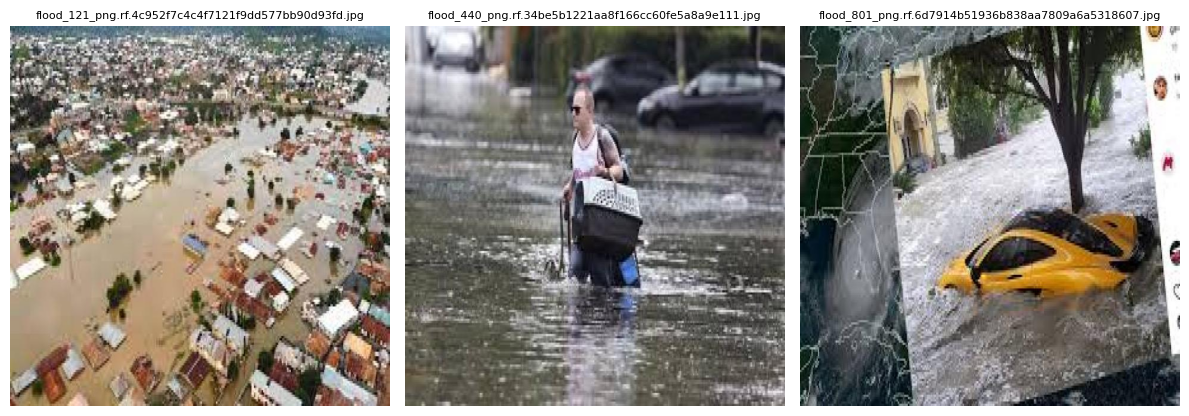

===== Test Images =====
Number of images found in /kaggle/input/obj-detectdataset/Obj_DetectDataset/test/images: 32


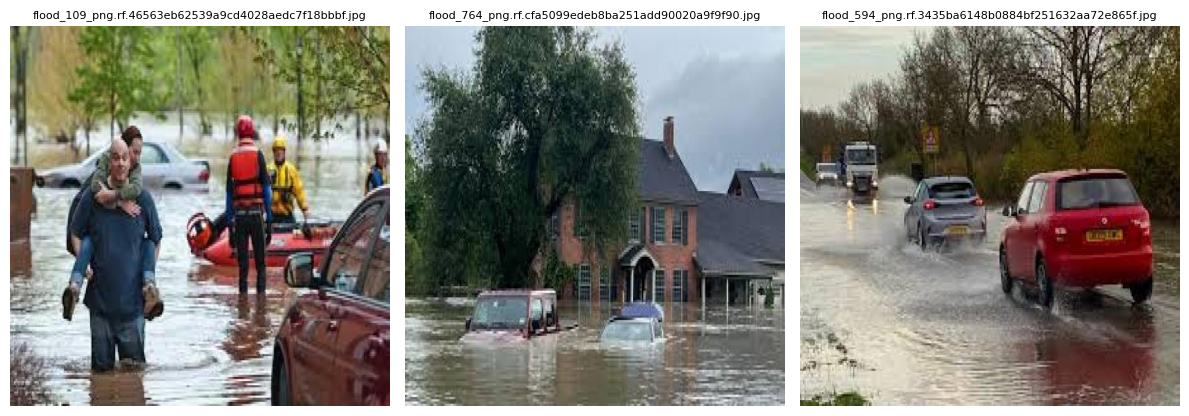

===== Valid Images =====
Number of images found in /kaggle/input/obj-detectdataset/Obj_DetectDataset/valid/images: 66


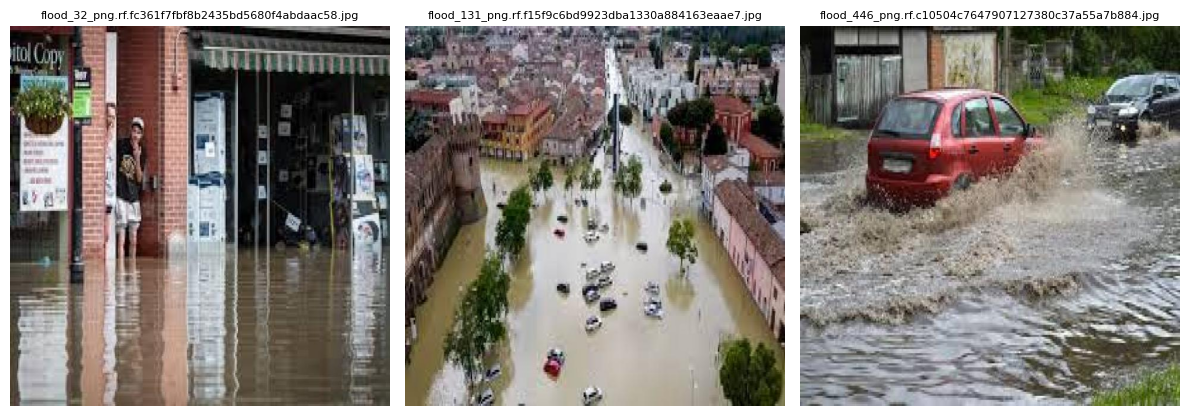

In [35]:
# Function to display images from a given directory
def display_images(image_path, num_images_to_display=3):
    # Get image file paths
    image_files = [os.path.join(image_path, f) for f in os.listdir(image_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]  # Filter images only

    print(f"Number of images found in {image_path}: {len(image_files)}")

    # Select images to display 
    images_to_display = image_files[:num_images_to_display]

    # Set grid size (3 images per row)
    cols = 3  # Number of columns
    rows = (len(images_to_display) // cols) + (len(images_to_display) % cols > 0)  # Dynamic row count

    plt.figure(figsize=(12, 8))  # Adjust figure size

    for idx, img_full_path in enumerate(images_to_display, 1):
        try:
            image = Image.open(img_full_path)  # Open image using PIL
            plt.subplot(rows, cols, idx)
            plt.imshow(image)
            plt.axis('off')
            plt.title(os.path.basename(img_full_path), fontsize=8)
        except Exception as e:
            print(f"Error with {img_full_path}: {str(e)}")  # More detailed error

    plt.tight_layout()
    plt.show()

# Display images for train, test, and valid directories
print("===== Train Images =====")
display_images(train_image_path)

print("===== Test Images =====")
display_images(test_image_path)

print("===== Valid Images =====")
display_images(val_image_path)

In [32]:
# Create a .yaml file

# Define dataset paths
data_config = {
    "train": "/kaggle/working/Obj_DetectDataset/train/images",
    "val": "/kaggle/working/Obj_DetectDataset/valid/images",
    "test": "/kaggle/working/Obj_DetectDataset/test/images",
    "nc": 3,  # Number of classes
    "names": ['flooded_building', 'flooded_car', 'person']  # Class names
}

# Save to YAML file

yaml_path = "/kaggle/working/Obj_DetectDataset/my_data.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"data.yaml saved at {yaml_path}")

data.yaml saved at /kaggle/working/Obj_DetectDataset/my_data.yaml


In [33]:
# Load YOLOv8 model
model = yolo.to(device)

print("Training started successfully!")

# Train with data augmentation enabled and save
model.train(
    data='/kaggle/working/Obj_DetectDataset/my_data.yaml',  # Path to my_data.yaml
    epochs=10000,                      # Number of training epochs
    imgsz=640,                      # Image size
    batch=16,
    project="/kaggle/working/yolo_runs",
    name="flood damage object detection",
    save_period=100,
    augment=True,                   # Enable data augmentation
    patience= 100,                   
    lr0=0.001,
    mixup=0.3, 
    mosaic=True,
    warmup_epochs=3,               # To stabilize early training
    cos_lr=True                    
)

Training started successfully!
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/Obj_DetectDataset/my_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10000, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=True, multi_scale=False, name=flood damage object detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, 

100%|██████████| 755k/755k [00:00<00:00, 135MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 245MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1521.9±530.7 MB/s, size: 61.2 KB)


train: Scanning /kaggle/working/Obj_DetectDataset/train/labels... 232 images, 11 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<00:00, 1580.61it/s]

train: New cache created: /kaggle/working/Obj_DetectDataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 466.5±57.0 MB/s, size: 67.0 KB)


val: Scanning /kaggle/working/Obj_DetectDataset/valid/labels... 66 images, 1 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1361.79it/s]

val: New cache created: /kaggle/working/Obj_DetectDataset/valid/labels.cache


Plotting labels to /kaggle/working/yolo_runs/flood damage object detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo_runs/flood damage object detection
Starting training for 10000 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    1/10000      7.87G      2.381      3.629       2.45         64        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         66        249      0.156      0.094     0.0687     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    2/10000      7.88G      2.238      2.837      2.263         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         66        249      0.303      0.187      0.162     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    3/10000      7.89G      2.218      2.481      2.167         65        640: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         66        249      0.509      0.296      0.285      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    4/10000      7.89G      2.041      2.304      2.023         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         66        249      0.414      0.287      0.288      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    5/10000      7.89G      1.997      2.069      1.947         43        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         66        249      0.305      0.279      0.244     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    6/10000      7.89G      1.913      2.175      1.895         34        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.321      0.175      0.149      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    7/10000      7.89G      1.952      2.205      1.917         45        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         66        249      0.347      0.201      0.194      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    8/10000      7.89G      1.918      2.231      1.938         45        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.325      0.319      0.229     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    9/10000      7.89G      1.934      2.201      1.932         65        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.454      0.253      0.241     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   10/10000      7.89G      1.877      2.136      1.853         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249       0.33      0.165      0.153     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   11/10000      7.89G      1.927      2.061       1.87        108        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.334      0.319      0.254     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   12/10000      7.89G      1.898      1.967       1.85         37        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.325      0.331      0.221     0.0741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   13/10000      7.89G      1.972      1.977      1.878        102        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.391      0.361      0.293     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   14/10000      7.89G      1.878      1.913       1.85         78        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.385      0.357      0.271     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   15/10000      7.89G      1.877      1.851      1.868         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.378      0.346      0.266     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   16/10000      7.89G      1.846      1.878      1.857         54        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         66        249      0.441      0.334      0.314      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   17/10000      7.89G      1.862      1.839      1.863         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.354      0.348      0.258     0.0935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   18/10000      7.89G      1.818      1.762      1.807         88        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.384      0.349      0.298     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   19/10000      7.89G      1.835      1.822      1.828        106        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         66        249      0.378      0.307      0.277     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   20/10000      7.89G      1.785      1.786      1.795        146        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.345      0.321      0.291     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   21/10000      7.89G      1.805      1.725      1.796         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         66        249      0.428      0.408       0.37      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   22/10000      7.89G      1.817      1.674      1.815        146        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         66        249      0.451      0.352      0.312      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   23/10000      7.89G      1.715      1.585      1.743         46        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.491      0.306      0.298      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   24/10000      7.89G      1.777      1.649      1.754         53        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         66        249      0.411      0.364      0.334      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   25/10000      7.89G      1.742      1.619      1.753        122        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         66        249      0.372      0.319      0.288     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   26/10000      7.89G      1.732      1.572       1.74         51        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         66        249      0.366      0.284      0.265     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   27/10000      7.89G      1.704      1.619      1.745         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.425      0.363      0.315     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   28/10000      7.89G      1.715      1.624      1.756         96        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.397      0.297      0.284     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   29/10000      7.89G      1.682      1.615      1.747         53        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.468      0.336      0.324      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   30/10000      7.89G      1.685      1.583      1.715         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.518      0.368      0.355      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   31/10000      7.89G      1.656      1.553      1.723         47        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.417        0.4      0.324      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   32/10000      7.89G      1.661      1.506      1.699         90        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.483       0.29      0.295      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   33/10000      7.89G      1.656      1.513      1.708        102        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.379      0.381      0.297     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   34/10000      7.89G      1.682       1.53      1.706         82        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         66        249      0.422      0.343      0.298     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   35/10000      7.89G      1.666        1.5      1.717         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.423      0.315      0.286     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   36/10000      7.89G      1.681      1.566      1.752         48        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249       0.43      0.354      0.304      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   37/10000      7.89G      1.625      1.458      1.687         72        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.417       0.33      0.284     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   38/10000      7.89G      1.562      1.422      1.668         66        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.417       0.35      0.329      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   39/10000      7.89G      1.556      1.386      1.606         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.518      0.345       0.36      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   40/10000      7.89G      1.583      1.433      1.656         84        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.479      0.382      0.346      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   41/10000      7.89G       1.54      1.401      1.633        129        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.527      0.331      0.342      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   42/10000      7.89G      1.582      1.425      1.642         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.467      0.329       0.34      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   43/10000      7.89G      1.526      1.434      1.624        124        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.449      0.379      0.352      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   44/10000      7.89G       1.52      1.316      1.575         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.378      0.375      0.335      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   45/10000      7.89G      1.506      1.285      1.578         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         66        249      0.576      0.305      0.366      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   46/10000      7.89G      1.556      1.376      1.628         73        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         66        249      0.445       0.35       0.31       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   47/10000      7.89G      1.525      1.387      1.619         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.405      0.416      0.342      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   48/10000      7.89G      1.465      1.287       1.57         58        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.462      0.411      0.389      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   49/10000      7.89G      1.468      1.264       1.55         58        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.465       0.39      0.391      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   50/10000      7.89G      1.506      1.321      1.586         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.409      0.387      0.324      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   51/10000      7.89G      1.493      1.299      1.577         95        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.463      0.369      0.354       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   52/10000      7.89G      1.456      1.293      1.564         71        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.476      0.335      0.316      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   53/10000      7.89G      1.446      1.236      1.551         77        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.458      0.322      0.302      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   54/10000      7.89G      1.425      1.278      1.568         65        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.493      0.376      0.369      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   55/10000      7.89G      1.473      1.314      1.585         47        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.434      0.392      0.359      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   56/10000      7.89G      1.362      1.177       1.48         74        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249       0.44      0.373      0.336      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   57/10000      7.89G      1.412       1.24      1.521        124        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.448      0.378      0.342       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   58/10000      7.89G      1.435      1.264      1.534         55        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.428       0.34      0.303      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   59/10000      7.89G      1.398      1.183      1.496         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.415      0.277      0.289     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   60/10000      7.89G       1.37      1.207      1.471         79        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.469       0.27      0.291     0.0937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   61/10000      7.89G       1.37      1.161      1.477         85        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.395      0.334      0.292      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   62/10000      7.89G      1.344      1.139      1.457         50        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.415       0.33      0.259     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   63/10000      7.89G      1.333      1.197      1.489         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.477      0.335      0.311      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   64/10000      7.89G      1.368      1.183      1.483         45        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.447      0.363      0.316      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   65/10000      7.89G      1.354      1.177       1.49         58        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.462      0.374      0.334      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   66/10000      7.89G      1.275      1.089      1.428         54        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.517      0.247      0.287     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   67/10000      7.89G      1.371      1.235      1.511         86        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.462      0.407      0.348      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   68/10000      7.89G      1.427      1.214      1.536         99        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.478      0.278      0.293     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   69/10000      7.89G      1.378      1.238      1.504         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.474      0.367      0.345      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   70/10000      7.89G      1.363      1.188      1.484         80        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.536      0.322      0.323      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   71/10000      7.89G      1.311       1.12      1.469         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.583      0.356      0.374      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   72/10000      7.89G      1.284      1.061      1.449         36        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.477       0.37      0.351      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   73/10000      7.89G      1.291      1.066      1.417         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.513      0.345      0.342      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   74/10000      7.89G      1.307      1.098      1.454         64        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.504      0.355       0.34      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   75/10000      7.89G      1.251      1.083      1.409         27        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.437      0.374       0.34      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   76/10000      7.89G       1.28      1.087      1.433         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.415      0.324      0.319      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   77/10000      7.89G      1.257      1.087      1.435         65        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.502      0.271      0.276      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   78/10000      7.89G      1.352      1.169      1.487        109        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.442      0.304      0.306      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   79/10000      7.89G      1.352      1.186      1.479         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.425      0.336      0.295      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   80/10000      7.89G      1.305      1.141      1.431         60        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.468      0.312      0.318      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   81/10000      7.89G       1.28      1.101      1.422         75        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.508      0.349       0.35      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   82/10000      7.89G       1.26      1.129      1.423         72        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.486      0.383       0.38      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   83/10000      7.89G      1.268      1.088      1.413         60        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         66        249      0.445      0.401      0.372       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   84/10000      7.89G       1.24      1.066      1.401         71        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.482      0.359      0.347      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   85/10000      7.89G      1.258      1.078      1.415         45        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249       0.51      0.333      0.304      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   86/10000      7.89G      1.222      0.997      1.368        115        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         66        249      0.393      0.359      0.301      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   87/10000      7.89G      1.216      1.005      1.372         68        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.418       0.38      0.335      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   88/10000      7.89G      1.263      1.018      1.414         74        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.474      0.344      0.337      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   89/10000      7.89G      1.269      1.087      1.404         64        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.411      0.355      0.311      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   90/10000      7.89G      1.181      1.007      1.354         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.374      0.327      0.272     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   91/10000      7.89G      1.242      1.031      1.397         38        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.441      0.325       0.31     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   92/10000      7.89G      1.255      1.045       1.42         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.395      0.372      0.323      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   93/10000      7.89G      1.175     0.9861      1.355         80        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.395      0.367       0.32      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   94/10000      7.89G      1.249      1.075      1.414        103        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.453      0.319      0.317     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   95/10000      7.89G      1.212     0.9977      1.353        112        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.431      0.382      0.327      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   96/10000      7.89G      1.163      0.971      1.331         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.479      0.299        0.3      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   97/10000      7.89G      1.214      1.001      1.376         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.477      0.256      0.256     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   98/10000      7.89G      1.153       0.93      1.333         70        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.493      0.312      0.293      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   99/10000      7.89G      1.197      1.007      1.369         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.485      0.286       0.28      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  100/10000      7.89G      1.187      1.015      1.359         83        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.421      0.357      0.302      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  101/10000      7.89G      1.151     0.9458      1.343         68        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.466      0.328      0.303      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  102/10000      7.89G      1.188      1.016      1.388         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.572      0.339      0.367      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  103/10000      7.89G      1.143     0.9512      1.357         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.512      0.329      0.331      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  104/10000      7.89G      1.134      0.909      1.318        104        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.536      0.337      0.342      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  105/10000      7.89G      1.106     0.9351       1.31         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         66        249      0.542      0.335      0.347      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  106/10000      7.89G      1.177      1.025      1.368         72        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.413      0.358      0.337      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  107/10000      7.89G      1.171      0.961      1.335         87        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.508      0.328      0.324      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  108/10000      7.89G      1.148     0.9585       1.33         48        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.449      0.331      0.334      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  109/10000      7.89G      1.214      1.066      1.422         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.366      0.337      0.319      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  110/10000      7.89G      1.096     0.9657      1.332         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.507      0.364      0.358      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  111/10000      7.89G      1.117     0.9571      1.337         53        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.484      0.348       0.36      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  112/10000      7.89G      1.158     0.9751      1.351         94        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.471      0.392      0.348       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  113/10000      7.89G      1.097      0.888      1.296         65        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.405       0.36      0.332      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  114/10000      7.89G        1.1     0.9319      1.312        109        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.483      0.371      0.358       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  115/10000      7.89G      1.136     0.9497      1.359        154        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.423      0.373      0.318      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  116/10000      7.89G      1.098     0.9273      1.319         73        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.475      0.373      0.354      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  117/10000      7.89G      1.077     0.8872      1.313         41        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.451      0.323      0.291      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  118/10000      7.89G      1.133       1.01      1.363         86        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.458      0.336      0.309      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  119/10000      7.89G      1.088     0.9344      1.324         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.435      0.365      0.313      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  120/10000      7.89G       1.14     0.9768      1.329         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.581      0.288      0.312      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  121/10000      7.89G      1.088     0.9602      1.319         63        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.472      0.382      0.342      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  122/10000      7.89G      1.088     0.9196       1.31         60        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.467      0.328      0.307      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  123/10000      7.89G      1.108     0.9186        1.3         55        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.395      0.305      0.276      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  124/10000      7.89G      1.136     0.9558      1.324         46        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.438      0.286       0.27      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  125/10000      7.89G      1.089     0.9361       1.31         52        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249       0.43      0.368      0.293      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  126/10000      7.89G       1.08     0.9441      1.322         71        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.455      0.332      0.301      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  127/10000      7.89G       1.08     0.9178      1.303         87        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.447      0.349      0.322      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  128/10000      7.89G      1.059     0.9085      1.289         71        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.404      0.358      0.334      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  129/10000      7.89G      1.107     0.9662      1.321         89        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.466      0.308      0.318       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  130/10000      7.89G      1.089     0.9336      1.331         68        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.423      0.347      0.337      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  131/10000      7.89G      1.081     0.9113      1.312         68        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.546      0.319      0.327      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  132/10000      7.89G      1.086     0.9044        1.3         42        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.559      0.356      0.365      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  133/10000      7.89G      1.094     0.9239      1.321         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.503      0.323      0.321      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  134/10000      7.89G      1.058     0.9025      1.299         90        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249       0.44      0.308      0.271     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  135/10000      7.89G      1.087     0.9125      1.308         41        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.494      0.294      0.285      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  136/10000      7.89G      1.015     0.8708      1.249         41        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.521       0.28        0.3      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  137/10000      7.89G      1.063     0.8884      1.266         64        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.382      0.333      0.307      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  138/10000      7.89G       1.07     0.8707      1.275         55        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.395      0.338      0.311      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  139/10000      7.89G       1.11     0.9221      1.309         82        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         66        249      0.441      0.326      0.299      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  140/10000      7.89G      1.085     0.9221      1.297         55        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.388      0.292      0.268      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  141/10000      7.89G      1.047     0.8911      1.284         66        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         66        249      0.375      0.308      0.265     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  142/10000      7.89G      1.036     0.8529      1.266        124        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.485      0.279      0.279        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  143/10000      7.89G      1.082     0.9177      1.293         74        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.334       0.29      0.232     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  144/10000      7.89G       1.02     0.8781      1.251         49        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         66        249       0.41      0.337      0.296      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  145/10000      7.89G      1.091     0.9142      1.302         66        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.452       0.33      0.303      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  146/10000      7.89G      1.068     0.9175      1.302         64        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.468      0.377      0.327      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  147/10000      7.89G      1.044     0.8745      1.293         71        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249       0.45      0.406       0.34      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  148/10000      7.89G      1.068     0.8628      1.273         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.501      0.392      0.357      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  149/10000      7.89G     0.9538     0.7893      1.216         54        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.458      0.388      0.333      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  150/10000      7.89G      1.049     0.8791       1.29         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.468      0.323      0.313      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  151/10000      7.89G      1.058     0.9026      1.297         63        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         66        249      0.501      0.273      0.281        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  152/10000      7.89G      1.035     0.8486      1.277         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.381      0.297      0.277      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  153/10000      7.89G      1.066     0.9129      1.314         35        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.411      0.359      0.303      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  154/10000      7.89G      1.009     0.8202      1.252         73        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.359      0.338      0.285      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  155/10000      7.89G     0.9984     0.8493      1.253         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249       0.43      0.306      0.296      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  156/10000      7.89G     0.9694     0.8304      1.247         44        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.432      0.311      0.287      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  157/10000      7.89G     0.9981     0.8325      1.252         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.388      0.332      0.292      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  158/10000      7.89G      1.061     0.9232      1.317         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.517      0.264      0.291     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  159/10000      7.89G       1.02     0.8505      1.261         71        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.474      0.316      0.318      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  160/10000      7.89G      1.091      0.947      1.327         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.525      0.306      0.333      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  161/10000      7.89G      1.015     0.8763      1.272         75        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.483       0.37      0.357      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  162/10000      7.89G      1.011     0.8253      1.262         54        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.402      0.362      0.322      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  163/10000      7.89G      1.005     0.8486      1.258        113        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.466      0.346      0.326       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  164/10000      7.89G      1.013     0.8314      1.267         75        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.426      0.368      0.326      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  165/10000      7.89G      1.008     0.8728      1.267         93        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         66        249      0.455      0.338      0.313      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  166/10000      7.89G     0.9642     0.7841      1.232         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.447      0.338      0.294      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  167/10000      7.89G      1.024     0.8417      1.266         29        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.434      0.337      0.291      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  168/10000      7.89G     0.9687     0.7991      1.225         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.485      0.331      0.312      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  169/10000      7.89G      1.027     0.8715      1.287         51        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.488      0.336      0.304      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  170/10000      7.89G      0.989      0.834       1.26         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.488      0.279      0.282      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  171/10000      7.89G     0.9753     0.8259      1.221         51        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.436      0.323      0.289      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  172/10000      7.89G      1.042     0.8676       1.29         31        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.466      0.309      0.306      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  173/10000      7.89G      1.015     0.8665      1.262         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.418      0.376      0.308      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  174/10000      7.89G     0.9575     0.8059      1.222         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.455      0.321      0.317      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  175/10000      7.89G     0.9766     0.8429      1.241         42        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         66        249      0.504      0.295      0.321      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  176/10000      7.89G     0.9881     0.8422      1.248         47        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.555      0.278      0.283      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  177/10000      7.89G     0.9932     0.8017      1.239         73        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.431       0.33      0.285     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  178/10000      7.89G     0.9941     0.8252      1.226         99        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.453      0.311      0.294        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  179/10000      7.89G      1.006     0.8429      1.272         77        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.446      0.317      0.287     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  180/10000      7.89G     0.9273     0.7776      1.202         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.501      0.326      0.303      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  181/10000      7.89G     0.9989     0.8509      1.255         69        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.394      0.301      0.285      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  182/10000      7.89G      1.013     0.8538      1.257         58        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.472      0.304      0.297      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  183/10000      7.89G     0.9686     0.8215      1.224         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.411      0.314      0.276      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  184/10000      7.89G     0.9365     0.7829      1.207         78        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.491      0.277      0.284      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  185/10000      7.89G     0.9103     0.7542      1.187         72        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.517      0.255      0.274      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  186/10000      7.89G     0.9022     0.7468      1.183         35        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.597      0.232      0.265     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  187/10000      7.89G     0.9535     0.8184      1.217         32        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.496      0.248      0.255     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  188/10000      7.89G     0.9918      0.873      1.253        109        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.499       0.28      0.279      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  189/10000      7.89G     0.9658     0.8341      1.245         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.428      0.283      0.273        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  190/10000      7.89G     0.9495     0.7927       1.22         51        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.442      0.348      0.298      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  191/10000      7.89G     0.9533     0.7999      1.227         72        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.407       0.32      0.275      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  192/10000      7.89G     0.9428     0.7999      1.203         66        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.485      0.273      0.292      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  193/10000      7.89G     0.9098     0.7892      1.205         88        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.447      0.323      0.284      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  194/10000      7.89G     0.9779      0.826      1.235         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.485      0.258      0.278     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  195/10000      7.89G     0.9582     0.7814      1.219         78        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.433      0.292      0.292       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  196/10000      7.89G     0.8993     0.7369      1.184         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         66        249      0.502      0.278      0.292       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  197/10000      7.89G     0.9796     0.8196      1.246         88        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.496      0.266      0.278      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  198/10000      7.89G     0.9469      0.802      1.227        107        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         66        249      0.481      0.277      0.294      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  199/10000      7.89G     0.9269     0.7891      1.235         27        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.473      0.309      0.289      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  200/10000      7.89G     0.9274     0.7937        1.2         78        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.479      0.317      0.311      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  201/10000      7.89G     0.9865     0.8229      1.239        105        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.504      0.327      0.323      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  202/10000      7.89G     0.9685     0.8085       1.24         78        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         66        249      0.506      0.326       0.32       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  203/10000      7.89G     0.9519     0.7759      1.222         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.428      0.335      0.302      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  204/10000      7.89G     0.9858     0.8762      1.252        100        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.447      0.283      0.284     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  205/10000      7.89G     0.9136     0.8064       1.23         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.501      0.287      0.287     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  206/10000      7.89G     0.9425     0.7838      1.232         53        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.378      0.319       0.28      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  207/10000      7.89G     0.9567      0.844      1.244         57        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.449      0.282       0.29      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  208/10000      7.89G     0.9244     0.7853      1.213         59        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.585      0.276        0.3       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  209/10000      7.89G      0.925     0.7702      1.199         73        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.468      0.312      0.303      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  210/10000      7.89G     0.9601     0.8105       1.22         99        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.624      0.279      0.302      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  211/10000      7.89G     0.9125     0.7802      1.205         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249       0.53      0.269      0.293      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  212/10000      7.89G     0.8915     0.7582      1.208         33        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.473       0.31      0.297      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  213/10000      7.89G     0.8855     0.7399      1.169         64        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.518      0.325      0.333      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  214/10000      7.89G     0.9383     0.8012      1.214         72        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249       0.53      0.358      0.339      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  215/10000      7.89G      0.913     0.7767      1.194         75        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.506      0.346      0.333      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  216/10000      7.89G     0.8772     0.7801      1.182         55        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.396      0.301      0.276      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  217/10000      7.89G     0.9385     0.7904      1.213         58        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.511      0.306      0.305      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  218/10000      7.89G     0.9457     0.8035      1.229         96        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.479      0.344      0.323      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  219/10000      7.89G      0.848     0.7143      1.145         95        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.496      0.327      0.317      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  220/10000      7.89G     0.9536     0.7867      1.227         56        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.465      0.284      0.296      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  221/10000      7.89G     0.9279     0.7589      1.195         74        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.417      0.324      0.302      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  222/10000      7.89G     0.9118     0.7478      1.191         67        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.603      0.294      0.311       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  223/10000      7.89G     0.8699     0.6895      1.167         81        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.566      0.343      0.338      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  224/10000      7.89G     0.9717     0.8048      1.234         51        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.502      0.327      0.303      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  225/10000      7.89G     0.9207     0.7935       1.21         62        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.477      0.327      0.303      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  226/10000      7.89G     0.8729     0.7042      1.149         78        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.472      0.304      0.299      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  227/10000      7.89G     0.8628     0.7432      1.153         55        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.513      0.305      0.293      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  228/10000      7.89G     0.9524     0.7873      1.213         89        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.543       0.31      0.307      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  229/10000      7.89G     0.8695     0.7141      1.163        104        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.553      0.299      0.311      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  230/10000      7.89G     0.8716     0.7152      1.164         74        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.654      0.316      0.324      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  231/10000      7.89G     0.9053     0.7554      1.195         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.519      0.284       0.29      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  232/10000      7.89G     0.9345     0.7692      1.215         61        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.525      0.248      0.264     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  233/10000      7.89G     0.9273     0.7794      1.221         46        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.382      0.275      0.259     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  234/10000      7.89G     0.9123     0.7354      1.187        132        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.464      0.281      0.291       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  235/10000      7.89G     0.8929      0.762      1.208         77        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.476      0.325      0.306      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  236/10000      7.89G     0.8961     0.7628      1.194         81        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.451      0.327      0.268      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  237/10000      7.89G     0.9047      0.742      1.186        117        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.473      0.261      0.256     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  238/10000      7.89G     0.8987     0.7494      1.197         49        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.542      0.255      0.269      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  239/10000      7.89G     0.9068     0.7554      1.183         60        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         66        249      0.536      0.231      0.267      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  240/10000      7.89G     0.8995     0.7772      1.203         66        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         66        249      0.501      0.269      0.287      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  241/10000      7.89G     0.8996     0.7527      1.184         80        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.506      0.294      0.296      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  242/10000      7.89G     0.9518     0.8436      1.228         76        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         66        249      0.486      0.284      0.279     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  243/10000      7.89G     0.9466     0.7964      1.214        125        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.559      0.254      0.258     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  244/10000      7.89G     0.8872     0.7489      1.185         38        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         66        249      0.439      0.292      0.245      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  245/10000      7.89G     0.9242     0.7753      1.219        116        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         66        249      0.538      0.263      0.279     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  246/10000      7.89G     0.9259     0.7639      1.205         53        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249      0.469      0.276      0.262     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  247/10000      7.89G     0.8757     0.7304      1.165         84        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         66        249       0.37       0.29      0.256     0.0928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  248/10000      7.89G        0.9     0.7735      1.191         87        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         66        249      0.603      0.234      0.275     0.0921
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 148, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



248 epochs completed in 0.724 hours.
Optimizer stripped from /kaggle/working/yolo_runs/flood damage object detection/weights/last.pt, 52.1MB
Optimizer stripped from /kaggle/working/yolo_runs/flood damage object detection/weights/best.pt, 52.1MB

Validating /kaggle/working/yolo_runs/flood damage object detection/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


                   all         66        249      0.404      0.417       0.36      0.144
      flooded_building         28         69      0.251      0.304      0.241     0.0896
           flooded_car         40         80      0.527      0.487      0.487       0.21
                person         25        100      0.434       0.46      0.353      0.131


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 30.0ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /kaggle/working/yolo_runs/flood damage object detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b87381bc050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [35]:
# Load trained model
best_model = YOLO("/kaggle/working/yolo_runs/flood damage object detection/weights/best.pt")

# Validate the model
metrics = best_model.val(data="/kaggle/working/Obj_DetectDataset/my_data.yaml")

# Print mAP scores
print("\nValidation Results:")
print(f"mAP@50: {metrics.box.map50:.4f}")  # mAP at IoU=0.50
print(f"mAP@50-95: {metrics.box.map:.4f}")  # mAP averaged over IoU=0.50:0.95

# Print class-wise metrics (correct approach)
print("\nClass-Wise Metrics:")
if hasattr(metrics.box, 'ap_class_index'):  # Check if per-class metrics are available
    for i, c in enumerate(metrics.box.ap_class_index):
        print(f"Class {c} ({metrics.names[c]}):")
        print(f"  Precision: {metrics.box.p[i]:.4f}")
        print(f"  Recall:    {metrics.box.r[i]:.4f}")
        print(f"  AP@50:     {metrics.box.ap50[i]:.4f}")
        print(f"  AP@50-95:  {metrics.box.ap[i]:.4f}")
else:
    print("Per-class metrics not available.")

# Print aggregate means
print("\nMean Metrics:")
print(f"Mean Precision (mp): {metrics.box.mp:.4f}")
print(f"Mean Recall (mr): {metrics.box.mr:.4f}")
print(f"mAP@50 (map50): {metrics.box.map50:.4f}")
print(f"mAP@50-95 (map): {metrics.box.map:.4f}")

Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1909.3±466.5 MB/s, size: 66.4 KB)


val: Scanning /kaggle/working/Obj_DetectDataset/valid/labels.cache... 66 images, 1 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


                   all         66        249      0.501      0.392      0.356      0.137
      flooded_building         28         69      0.362      0.333      0.266      0.105
           flooded_car         40         80      0.596      0.463      0.455      0.184
                person         25        100      0.544       0.38      0.348      0.123


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 4.8ms preprocess, 11.3ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/val2

Validation Results:
mAP@50: 0.3564
mAP@50-95: 0.1370

Class-Wise Metrics:
Class 0 (flooded_building):
  Precision: 0.3619
  Recall:    0.3333
  AP@50:     0.2661
  AP@50-95:  0.1048
Class 1 (flooded_car):
  Precision: 0.5959
  Recall:    0.4625
  AP@50:     0.4547
  AP@50-95:  0.1836
Class 2 (person):
  Precision: 0.5438
  Recall:    0.3800
  AP@50:     0.3484
  AP@50-95:  0.1227

Mean Metrics:
Mean Precision (mp): 0.5005
Mean Recall (mr): 0.3919
mAP@50 (map50): 0.3564
mAP@50-95 (map): 0.1370


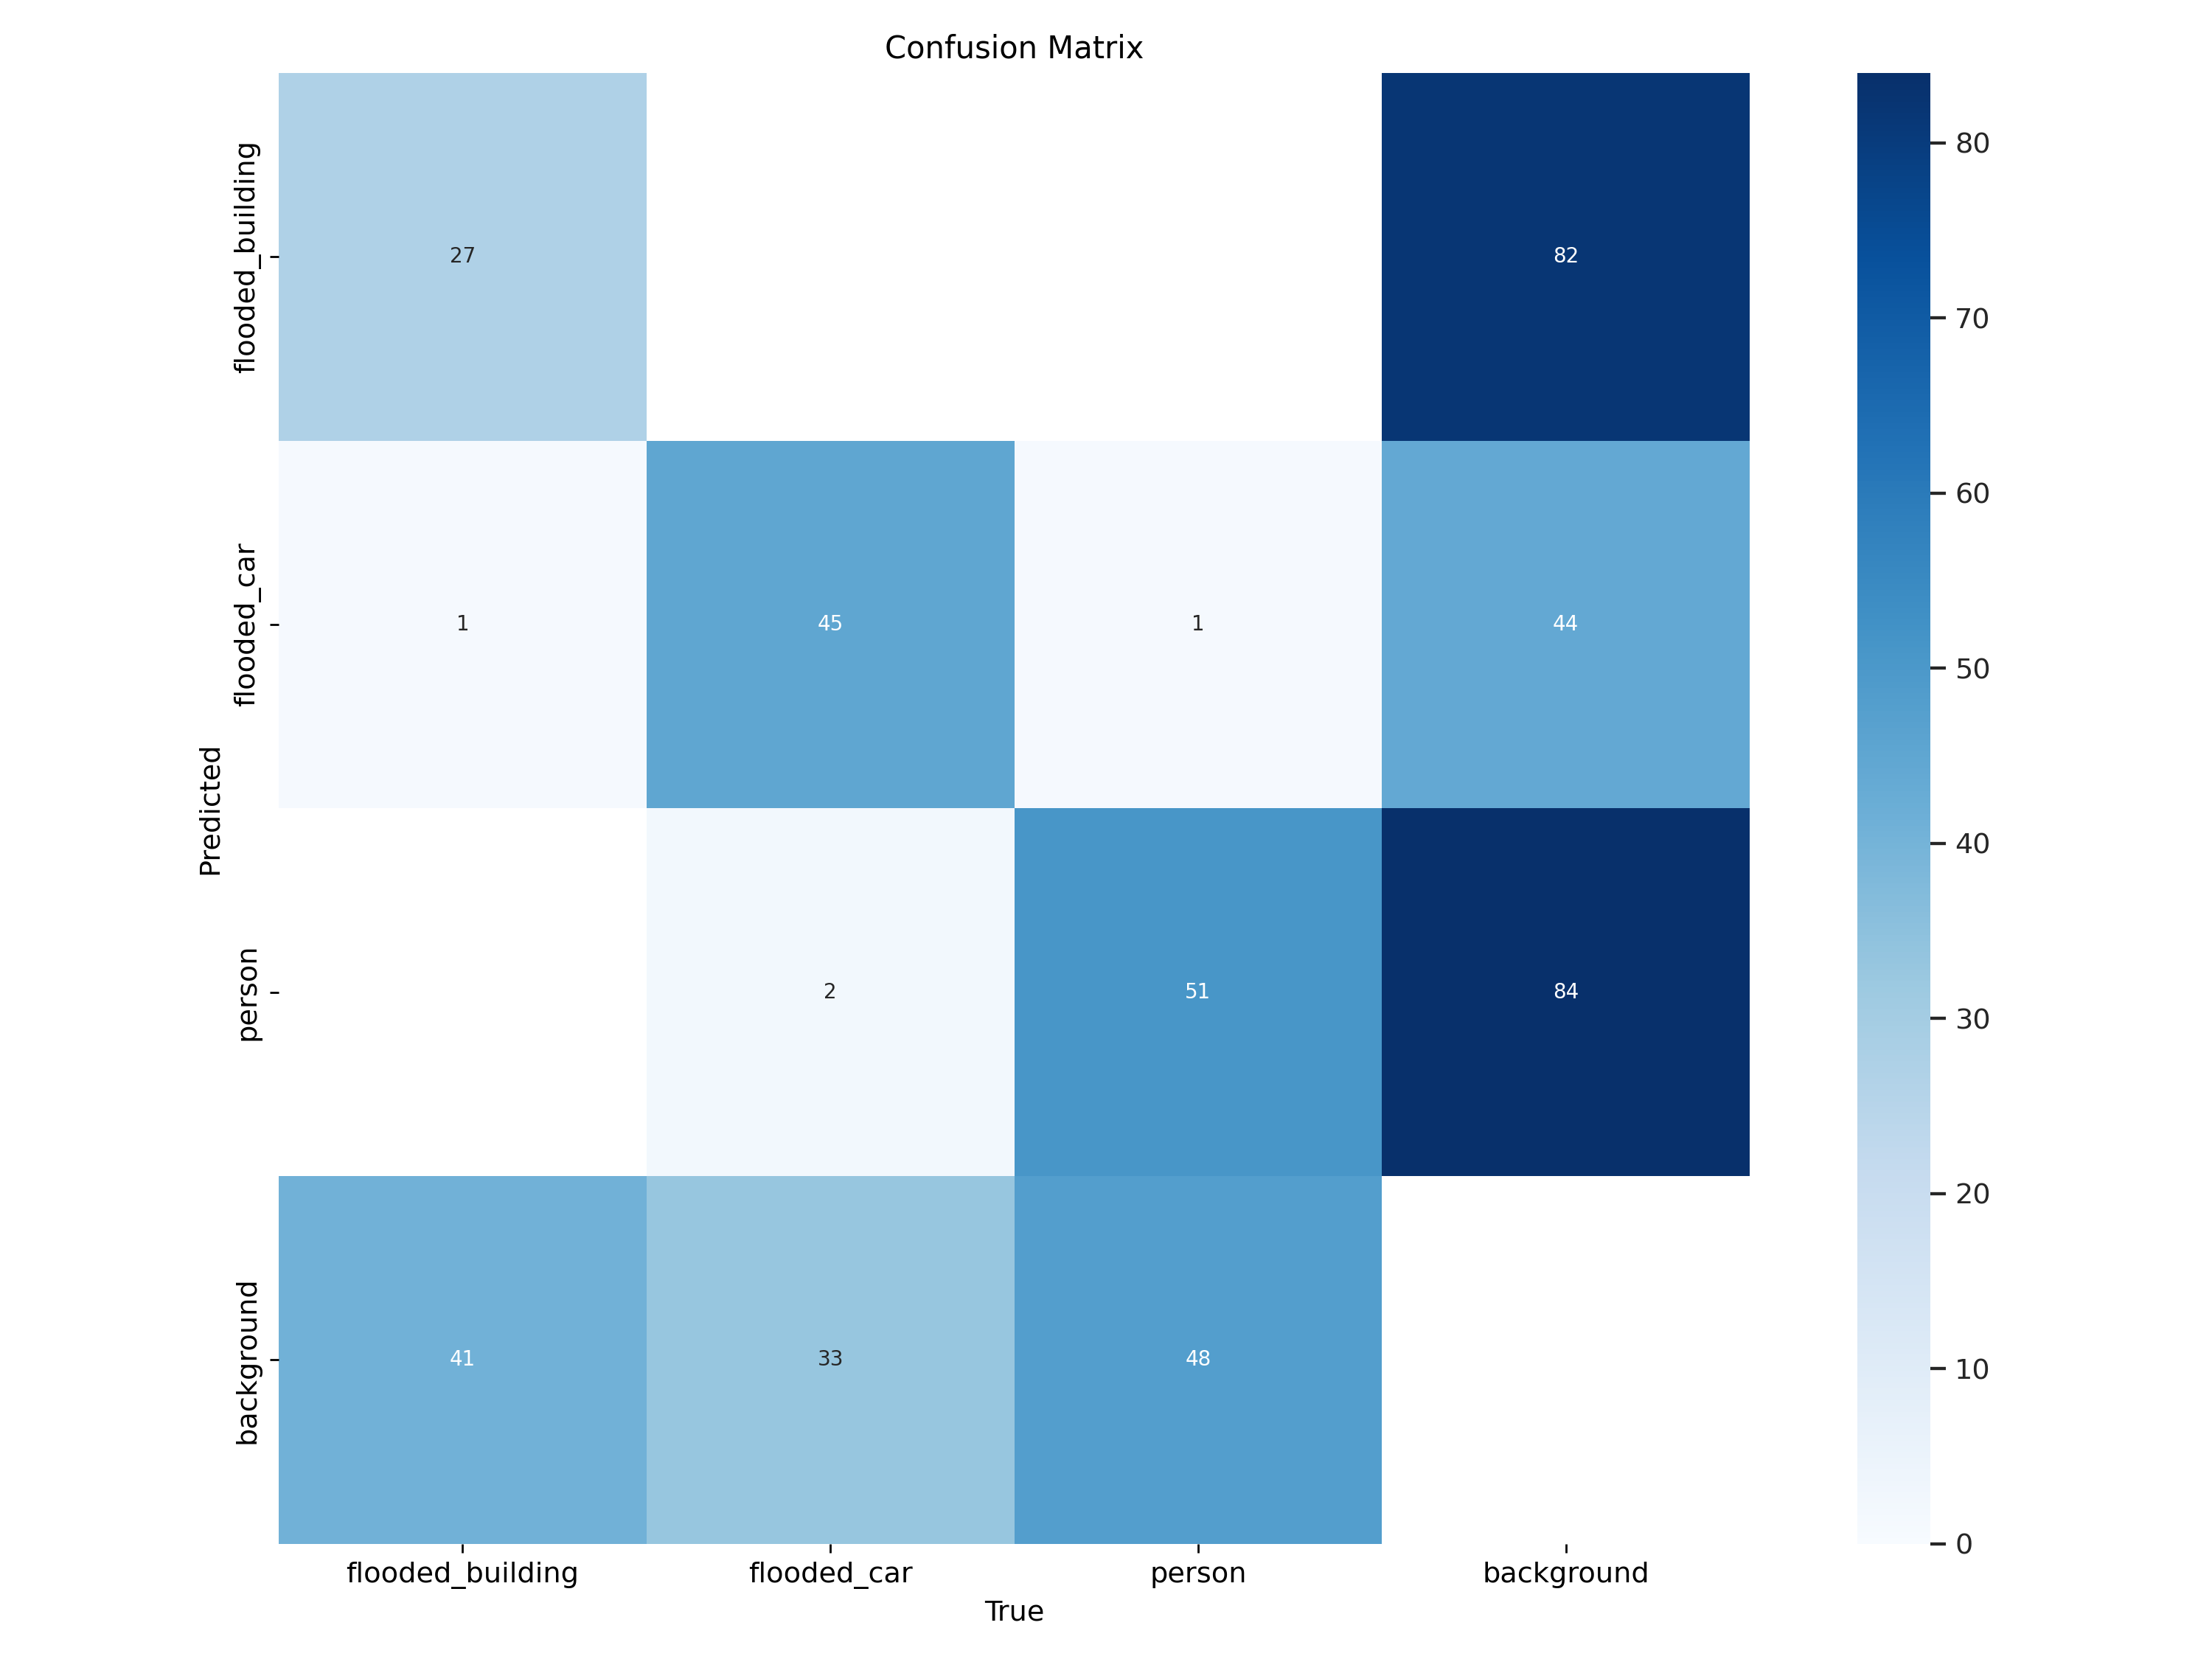

In [38]:
# Visualize Confusion Matrix
display(Image(filename='/kaggle/working/yolo_runs/flood damage object detection/confusion_matrix.png'))

Results saved to runs/detect/predict


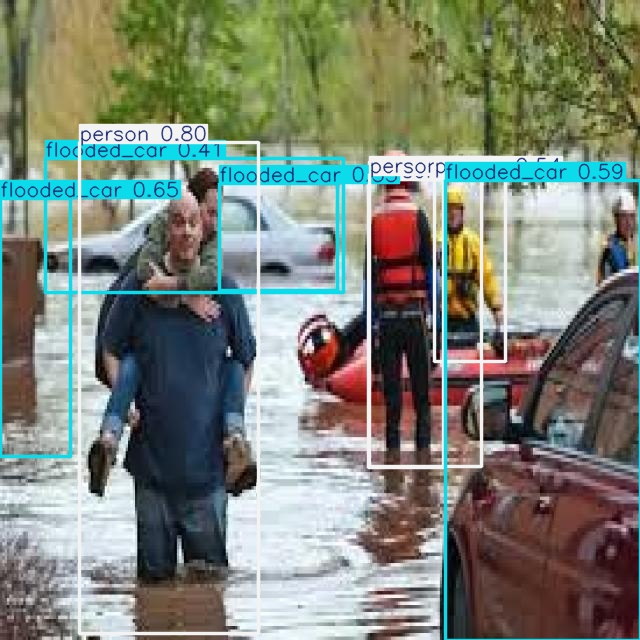

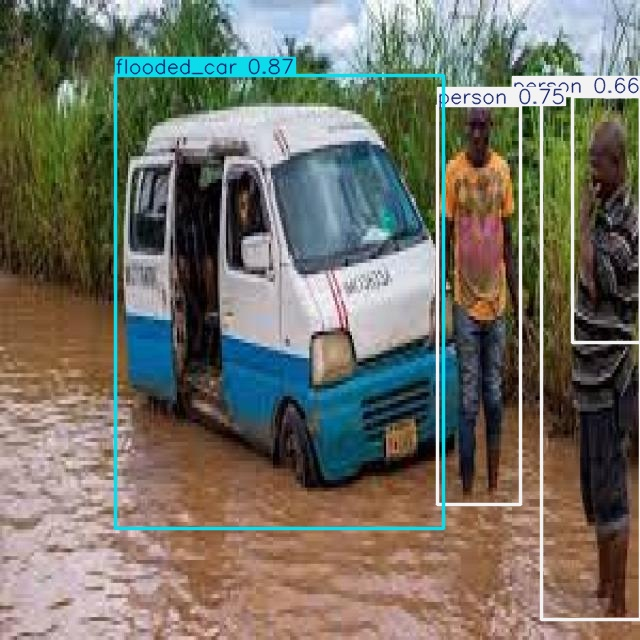

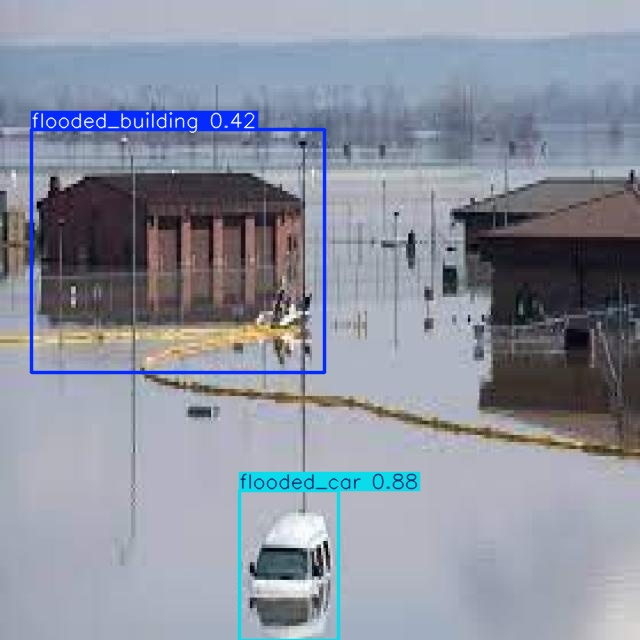

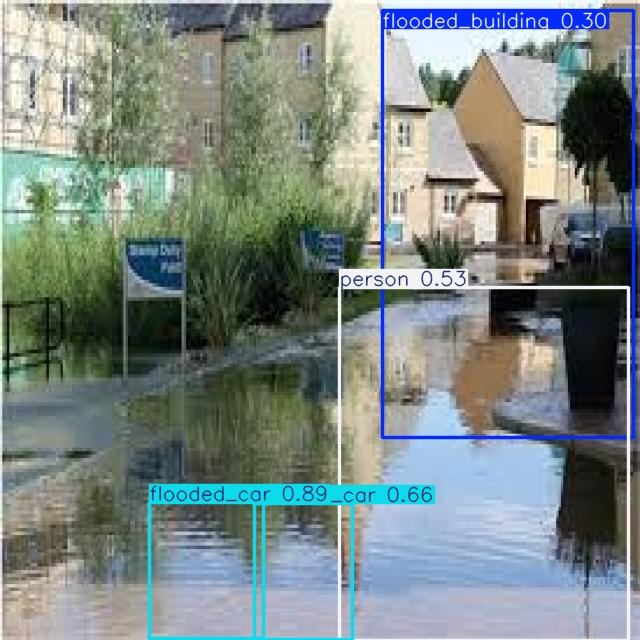

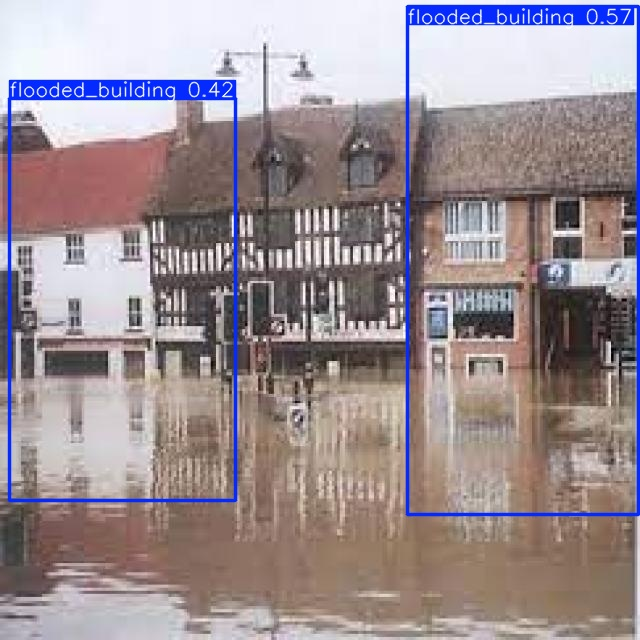

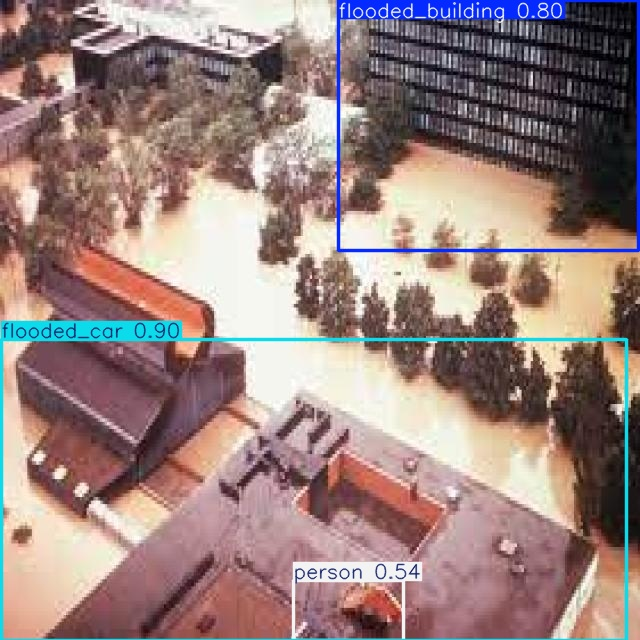

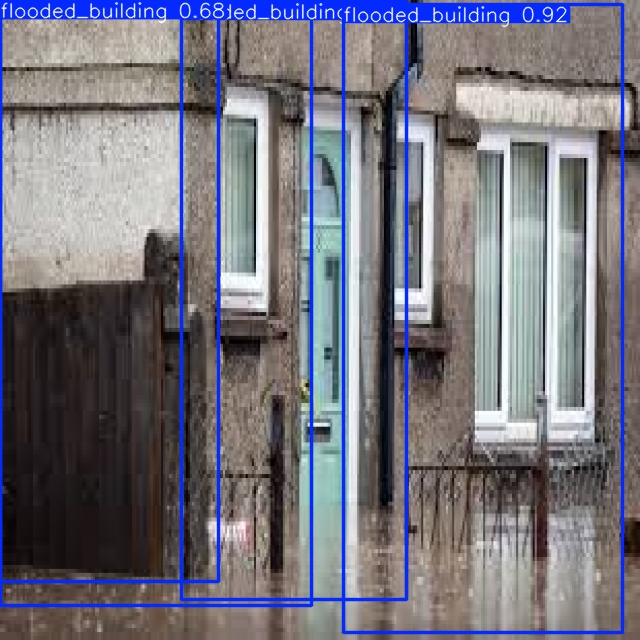

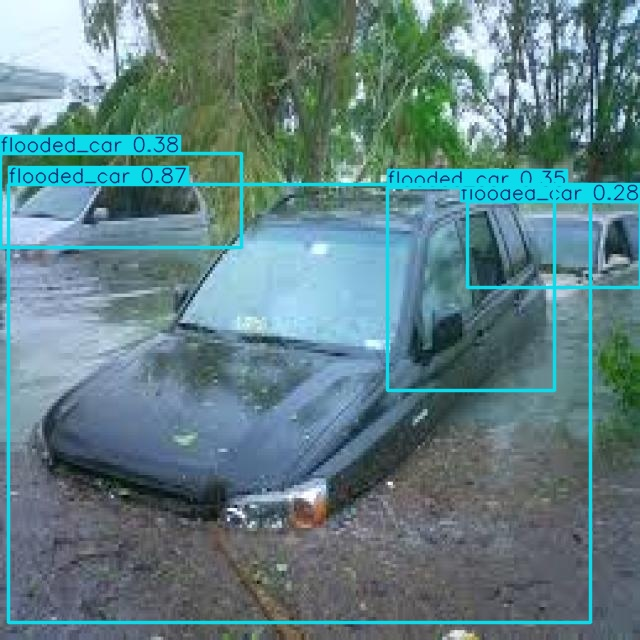

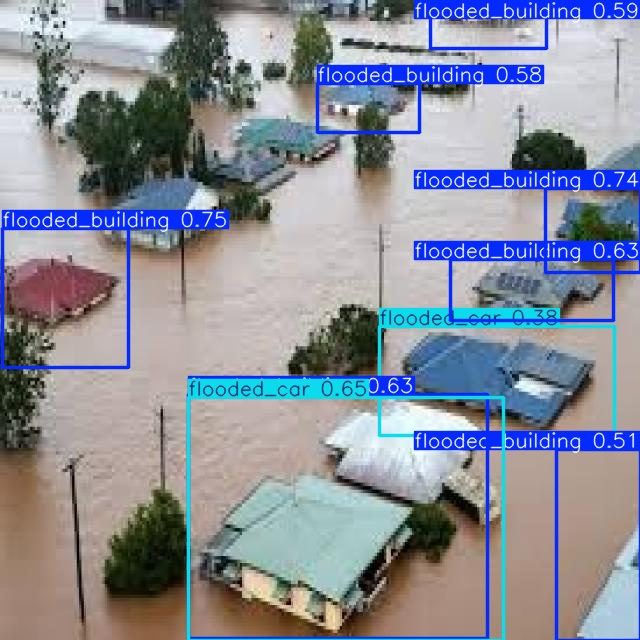

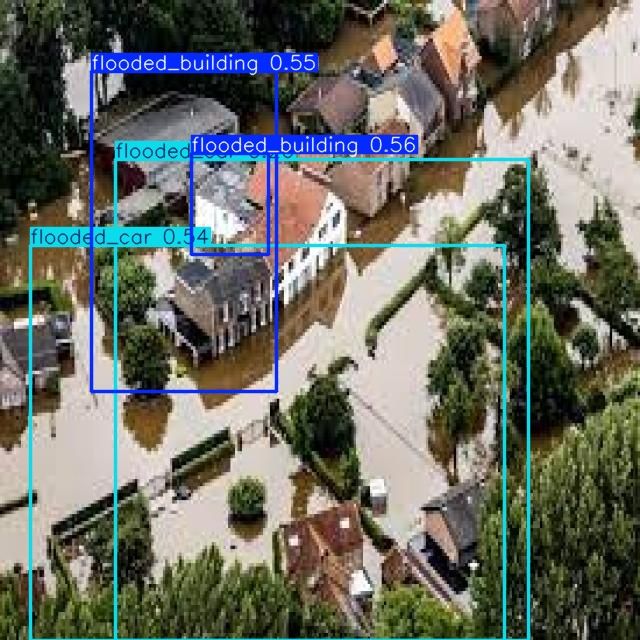

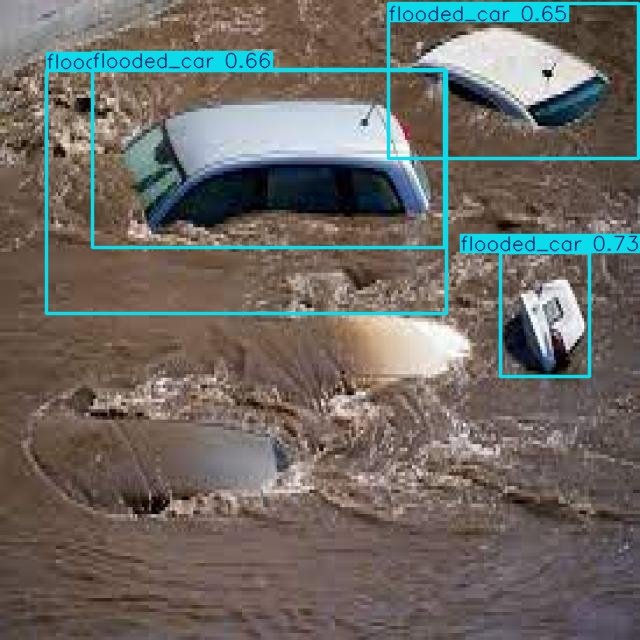

In [ ]:
# Run prediction on test images
results = best_model.predict(
    source="/kaggle/working/Obj_DetectDataset/test/images",
    save=True,
    conf=0.25,
    verbose=False  # 👈 This hides the per-image detection logs
)

# Get the directory where prediction images are saved
save_dir = results[0].save_dir

# Display saved images (predictions with labels and boxes)
for image_file in sorted(os.listdir(save_dir)):
    if image_file.lower().endswith((".jpg", ".jpeg", ".png")):
        display(Image(filename=os.path.join(save_dir, image_file)))